In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import os
os.chdir("/content/drive/My Drive/projects/og-chat")

In [4]:
!pip install transformers
!pip install datasets
!pip install pytorch_pretrained_bert

In [122]:
# med_dialog = load_dataset("medical_dialog", "en", data_dir="./Medical-Dialogue-Dataset-English")

In [5]:
from datasets import load_dataset
# raw_datasets = load_dataset("imdb")
covid_dialog = load_dataset("covid_qa_ucsd", "en", data_dir="./" )

Downloading:   0%|          | 0.00/3.50k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/805 [00:00<?, ?B/s]

Using custom data configuration en-data_dir=.%2F


0 examples [00:00, ? examples/s]

Dataset covid_qa_ucsd downloaded and prepared to /root/.cache/huggingface/datasets/covid_qa_ucsd/en-data_dir=.%2F/1.0.0/61d5d736f7a6a127fff0ac0182263d45c2e2192a6af6c4459f2d4a3d22083ef4. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
import pandas as pd

In [7]:
cd_df = covid_dialog['train'].to_pandas()

In [8]:
print(cd_df["dialogue_turns"])

0      {'speaker': [0, 1, 0, 1], 'utterance': ['I hav...
1      {'speaker': [0, 1, 0, 1, 0, 1, 0, 1], 'utteran...
2      {'speaker': [0, 1], 'utterance': ['Can Coronav...
3      {'speaker': [0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, ...
4      {'speaker': [0, 1], 'utterance': ['Does COVID-...
                             ...                        
567    {'speaker': [0, 1], 'utterance': ['If I get co...
568    {'speaker': [0, 1], 'utterance': ['I was on a ...
569    {'speaker': [0, 1], 'utterance': ['My son has ...
570    {'speaker': [0, 1], 'utterance': ['Can coronav...
571    {'speaker': [0, 1], 'utterance': ['Good day,  ...
Name: dialogue_turns, Length: 572, dtype: object


In [126]:
# We may want to parse all doctor, patient pairs and use that instead
# We also may want to consider truncating on the left (context) side
# Right now we are just generating text, there is no 
# text_to_answer = []
# for dial in cd_df["dialogue_turns"]:
#   u = dial["utterance"]
#   q = u[0]
#   a, u = u[-1], u[0:-1]
#   text_to_answer.append(['<|endoftext|>'.join(u), a])
# qa_df = pd.DataFrame(text_to_answer, columns=["text","answer"])

In [10]:
# Here we have only text 
text = []
for dial in cd_df["dialogue_turns"]:
  u = dial["utterance"]
  # text.append(['<|endoftext|>'.join(u)])
  text.append([''.join(u)])
qa_df = pd.DataFrame(text, columns=["text"])

In [9]:
qa_df["text"][0]

NameError: ignored

In [13]:
print(qa_df)

                                                  text
0    I have cough with no travel history. Is this a...
1    I have a little fever with no history of forei...
2    Can Coronavirus cause itchiness in throat and ...
3    I have chills, breathing problems and cough wi...
4    Does COVID-19 spreads through water? What prec...
..                                                 ...
567  If I get coronavirus, are there ways to avoid ...
568  I was on a plane on March 8th have been home e...
569  My son has a fever, I am concerned due to the ...
570  Can coronavirus symptoms be mild for some peop...
571  Good day,  I am 29 weeks pregnant and my profe...

[572 rows x 1 columns]


In [14]:
from transformers import AutoModelForCausalLM, AutoTokenizer, AdamW, GPT2LMHeadModel, GPT2DoubleHeadsModel, GPT2TokenizerFast, GPT2Config, BertTokenizer

from transformers.modeling_outputs import CausalLMOutputWithCrossAttentions
from transformers.models.gpt2.modeling_gpt2 import GPT2DoubleHeadsModelOutput
import copy
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from pytorch_pretrained_bert.modeling_gpt2 import GPT2PreTrainedModel, GPT2MultipleChoiceHead, GPT2Model, GPT2LMHead, Attention, Block, \
    LayerNorm, MLP

In [130]:
"""
Types
transformer_outputs => BaseModelOutputWithPastAndCrossAttentions
model => GPT2LMHeadModel 
"""

'\nTypes\ntransformer_outputs => BaseModelOutputWithPastAndCrossAttentions\nmodel => GPT2LMHeadModel \n'

In [131]:
"""
There is currently a bug in the implementation which results 
in zero loss for the zero reward values. This must be re-evaluated
"""

'\nThere is currently a bug in the implementation which results \nin zero loss for the zero reward values. This must be re-evaluated\n'

In [132]:
class BudgieNet(GPT2LMHeadModel):
    def __init__(self, config):
        super().__init__(config)
        self.interesting_head = GPT2LMHead(self.transformer.wte.weight, config)
        self.funny_head = GPT2LMHead(self.transformer.wte.weight, config)
        self.choosing_head = nn.Linear(self.transformer.wte.weight.size()[-1], 2)
        self.choice_dispatch = {0: self.interesting_head, 1: self.funny_head}
        self.rewards = {0: [], 1: []}  # max rewards hardcoded with even distribution of funny and interesting ie. 5:5
        self.correct = {0: [], 1: []} 
        self.scores = {0: [], 1: []}
        self.probs = {0: [], 1: []}
        self.combined_logits = {0: [], 1: []}
        self.logits = []
        self.chosen_head = None
        self.batch_size = 2
        self.index = 0
        self.choice = 0
        self.generating = False
        self.generation_step = -1

    def reset_state(self):
        self.generation_step = -1
        self.rewards = {0: [] , 1: []}  
        self.correct = {0: [], 1: []} 
        self.scores = {0: [], 1: []}
        self.probs = {0: [], 1: []}
        self.combined_logits = {0: [], 1: []}
        self.stop_generation()
        self.generation_step = -1

    def affirm_social(self, correct):
        if correct:
            self.correct[self.choice].append(1)
        else:    
            self.correct[self.choice].append(0)

    def affirm_reward(self, value):
        self.rewards[self.choice].append(value)
        
    def start_generation(self):
        self.generating = True

    def stop_generation(self):
        self.generating = False
        self.generation_step = -1

    def combine_logits(self):
        logits = torch.stack(self.logits)
        mean_logits = torch.mean(logits, dim=0).squeeze()
        self.combined_logits[self.choice].append(mean_logits)
        self.logits.clear()

    def increment(self):
        self.index += 1

    def choose(self, sentence):
        scores = F.relu(self.choosing_head(sentence))
        probs = F.softmax(scores, dim=-1)
        prob = torch.max(probs)
        idx = torch.argmax(probs)
        self.choice = idx.item()
        self.probs[self.choice].append(prob.item())
        self.scores[self.choice].append(scores)

    def calculate_rewarded_loss(self):
        loss = 0
        for i in range(2):
            combined = self.combined_logits[i]
            if not len(combined):
                loss += 0
                continue

            logits = torch.stack(combined, dim=0)
            rewards = torch.tensor(self.rewards[i])
            flipped_logits = torch.transpose(logits, 0, 1)
            rewarded_logits = torch.multiply(flipped_logits, rewards)
            rewarded_logits = torch.transpose(rewarded_logits, 0, 1)
            scores = torch.mean(rewarded_logits, dim=0)
            probs = F.softmax(scores, dim=-1)
            prob = torch.max(probs)
            print(f"reward prob: {prob}")
            loss += -1 * torch.log(prob)

        return loss

    def calculate_cross_entropy(self):
        loss = 0 
        for i in range(2):    
            iprobs = self.probs[i]
            original_length = len(iprobs)
            if not len(iprobs):
                loss += 0
                continue

            probs = torch.tensor(iprobs)
            mask = torch.tensor(self.correct[i], dtype=bool)
            partial_loss = torch.sum(probs[mask], dim=0) / original_length
            print(f"choice prob: {partial_loss}")
            partial_loss = -1 * torch.log(partial_loss)
            loss += partial_loss

        return loss

    def calculate_total_loss(self):
       return self.calculate_rewarded_loss() + self.calculate_cross_entropy()

    @torch.enable_grad()    
    def forward(
            self,
            input_ids=None,
            past_key_values=None,
            attention_mask=None,
            token_type_ids=None,
            position_ids=None,
            head_mask=None,
            inputs_embeds=None,
            labels=None,
            use_cache=None,
            output_attentions=None,
            output_hidden_states=None,
            return_dict=None,
        ):  
      
        transformer_outputs = self.transformer(
            input_ids=input_ids,
            past_key_values=past_key_values,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            use_cache=use_cache,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        last_hidden_state = transformer_outputs.last_hidden_state
        hidden_states = transformer_outputs.hidden_states
        past = transformer_outputs.past_key_values
        lm_logits = None
        loss = None
        if self.playmode:
            self.chosen_head = self.choice_dispatch[0]
            lm_logits = self.chosen_head(last_hidden_state)
            return CausalLMOutputWithCrossAttentions(
            loss=loss,
            logits=lm_logits,
            past_key_values=past,
            hidden_states=transformer_outputs.hidden_states,
            attentions=transformer_outputs.attentions,
          )
        if self.generating:
            lm_logits = self.chosen_head(last_hidden_state)
            if self.generation_step > 0:
                print(f"lm_logits.size: {lm_logits.size()}")
                self.logits.append(lm_logits)
        else:
            self.chosen_head = self.choice_dispatch[self.choice]
        
        self.generation_step += 1

        return CausalLMOutputWithCrossAttentions(
            loss=loss,
            logits=lm_logits,
            past_key_values=past,
            hidden_states=transformer_outputs.hidden_states,
            attentions=transformer_outputs.attentions,
        )
    

In [ ]:
# One problem with BudgieNet is it suffers from the credit assignment problem that comes with generating discrete tokens. We want to
# pass back a signal on the sentence level but are unable to do anything but on a word level.

In [63]:
# model = BudgieNet.from_pretrained("microsoft/DialoGPT-small", output_hidden_states = True)
dtokenizer = GPT2TokenizerFast.from_pretrained("microsoft/DialoGPT-small")
tokenizer = BertTokenizer.from_pretrained('dmis-lab/biobert-large-cased-v1.1')

HTTPError: ignored

In [134]:
tokenizer.save_pretrained("./tokenizer") 
dtokenizer.save_pretrained("./dtokenizer") 

('./dtokenizer/tokenizer_config.json',
 './dtokenizer/special_tokens_map.json',
 './dtokenizer/vocab.json',
 './dtokenizer/merges.txt',
 './dtokenizer/added_tokens.json',
 './dtokenizer/tokenizer.json')

In [135]:
vocab_dict = {}
cnt = 0
with open('./tokenizer/vocab.txt') as tfile:
  for line in tfile:
    l = line.rstrip()
    vocab_dict[cnt] = l
    cnt += 1

print(cnt)

58996


In [ ]:
vocab_dict

In [137]:
import json

In [138]:
json1 = json.load(open('./dtokenizer/vocab.json'))
# json2 = json.load(open('./tokenizer/vocab.json'))
# Use the vocab_dict here??

FileNotFoundError: ignored

In [58]:
string = "covid"
cough_token_bert = tokenizer(string)
cough_token_gpt = dtokenizer(string)
cb = cough_token_bert["input_ids"]
gp = cough_token_gpt["input_ids"]
# print(cough_token_gpt)
# print(cb)
# print(gp)
tokens_cb = tokenizer.convert_ids_to_tokens(cb)
tokens_gp = dtokenizer.convert_ids_to_tokens(gp)
print(f"GPT2 tokenizes {string} as : \n")
for i in range(len(gp)):
  tokens_gp = dtokenizer.convert_ids_to_tokens(gp[i])
  print(dtokenizer.convert_tokens_to_string(tokens_gp))
print(f"BioBert tokenizes {string} as : \n")
for j in range(len(cb)):
  tokens_cb = tokenizer.convert_ids_to_tokens(cb[j])
  print(tokenizer.convert_tokens_to_string(tokens_cb))

GPT2 tokenizes covid as : 

c
ov
id
BioBert tokenizes covid as : 

[ C L S ]
c o v
# # i d
[ S E P ]


In [31]:
# https://huggingface.co/transformers/main_classes/model.html
input_embs = model.get_input_embeddings()
output_embs = model.get_output_embeddings()


string1 = "I am headed to the bank to fish" + tokenizer.eos_token
string2 = "I am headed to the bank to get a loan" + tokenizer.eos_token
dog = "dog"
tokens1 = tokenizer.tokenize(string1)
tokens2 = tokenizer.tokenize(string2)
dog_tokens = tokenizer.tokenize(dog)
print(tokens1)
print(tokens2)
# print(dog_tokens)
ids1 = tokenizer(string1)['input_ids']
ids2 = tokenizer(string2)['input_ids']
ids3 = tokenizer(dog)['input_ids']
# print(ids1)
# print(ids2)
# print(ids3)
states1 = input_embs(torch.tensor(ids1, dtype=int))
states2 = input_embs(torch.tensor(ids2, dtype=int))
states3 = input_embs(torch.tensor(ids3, dtype=int))
print(states1[-2][0:5])
print(states2[-2][0:5])
# print(states2)
# print(states3)
word = output_embs(states)
tops = torch.topk(word, 20).indices
print(tops)
tokens = tokenizer.convert_ids_to_tokens(tops)
strings = tokenizer.convert_tokens_to_string(tokens)
print(strings)
# Convert string to sequence of tokens (WRONG)
# word = tokenizer.decode(14231)
# print(word)
# id = tokenizer.convert_tokens_to_ids(token)
# string = tokenizer.convert_tokens_to_string(token)
# token = tokenizer.convert_ids_to_tokens(id)


# print(id, token,string)

['I', 'Ġam', 'Ġheaded', 'Ġto', 'Ġthe', 'Ġbank', 'Ġto', 'Ġfish', '<|endoftext|>']
['I', 'Ġam', 'Ġheaded', 'Ġto', 'Ġthe', 'Ġbank', 'Ġto', 'Ġget', 'Ġa', 'Ġloan', '<|endoftext|>']


RuntimeError: ignored

In [ ]:
step = 0
model.playmode = True

while True:
    context = input(">> User:")
    if context == "I am done talking":
      print("DialoGPT: Ok bye bye")
      break
    # encode the new user input, add the eos_token and return a tensor in Pytorch
    new_user_input_ids = tokenizer(context, return_tensors='pt').input_ids

    # append the new user input tokens to the chat history
    bot_input_ids = torch.cat([chat_history_ids, new_user_input_ids], dim=-1) if step > 0 else new_user_input_ids

    # generated a response while limiting the total chat history to 1000 tokens, 
    chat_history_ids = model.generate(bot_input_ids, max_length=1000, return_dict=True, pad_token_id=tokenizer.eos_token_id)
    step += 1
    # pretty print last ouput tokens from bot
    print("DialoGPT: {}".format(tokenizer.decode(chat_history_ids[:, bot_input_ids.shape[-1]:][0], skip_special_tokens=True)))

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
optim = AdamW(model.parameters(), lr=5e-5)

In [ ]:
response_map = {1: "funny", 0:"interesting"}

In [ ]:
model.reset_state()
model.index = 0
while model.index < 100:
    while not (model.index % (model.batch_size + 1)) == 0:
        context = input(">> User:")
        # encode the new user input, add the eos_token and return a tensor in Pytorch
        new_user_input_ids = tokenizer(context + tokenizer.eos_token, return_tensors='pt').input_ids

        # append the new user input tokens to the chat history
        bot_input_ids = torch.cat([chat_history_ids, new_user_input_ids], dim=-1) if model.index > 1 else new_user_input_ids
        output = model(bot_input_ids)
        token_vecs = output.hidden_states[-2][0]
        sentence_embedding = torch.mean(token_vecs, dim=0)
        model.choose(sentence_embedding)
        model.start_generation()
        # average the second to last hiden layer of each token to get sentence rep

        # generated a response while limiting the total chat history to 1000 tokens, 
        chat_history_ids = model.generate(bot_input_ids, max_length=1000, return_dict=True, pad_token_id=tokenizer.eos_token_id)
        model.stop_generation()
        model.combine_logits()
        # pretty print last ouput tokens from bot
        print(chat_history_ids[:, bot_input_ids.shape[-1]:])
        print("DialoGPT: {}".format(tokenizer.decode(chat_history_ids[:, bot_input_ids.shape[-1]:][0], skip_special_tokens=True)))
        model.increment()
        social = input(f">> Should I have been {response_map[model.choice]} here ? - if not leave blank and enter")
        model.affirm_social(len(social))
        accurate = input(f">> Was this actually {response_map[model.choice]} ? - how much so 0-5 ")
        accurate = int(accurate) if len(accurate) else 0
        model.affirm_reward(accurate)

    if model.index != 0:
        print("Training the model")
        optim.zero_grad()
        loss = model.calculate_total_loss()
        model.reset_state()
        print(loss)
        loss.backward()
        optim.step()
    model.increment()


In [15]:
qa_df

,text
0,I have cough with no travel history. Is this a...
1,I have a little fever with no history of forei...
2,Can Coronavirus cause itchiness in throat and ...
3,"I have chills, breathing problems and cough wi..."
4,Does COVID-19 spreads through water? What prec...
...,...
567,"If I get coronavirus, are there ways to avoid ..."
568,I was on a plane on March 8th have been home e...
569,"My son has a fever, I am concerned due to the ..."
570,Can coronavirus symptoms be mild for some peop...


In [64]:
import os
import time
import datetime
# from google.colab import drive

import pandas as pd
import seaborn as sns
import numpy as np
import random

import matplotlib.pyplot as plt
% matplotlib inline

import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler
torch.manual_seed(42)

from transformers import GPT2LMHeadModel,  GPT2Tokenizer, GPT2Config, GPT2LMHeadModel
from transformers import AdamW, get_linear_schedule_with_warmup

import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [65]:
text = qa_df.text.copy()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


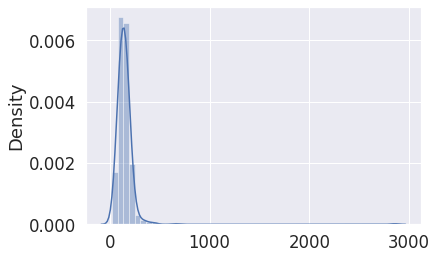

In [66]:
doc_lengths = []

for bio in text:

    # get rough token count distribution
    tokens = nltk.word_tokenize(bio)

    doc_lengths.append(len(tokens))

doc_lengths = np.array(doc_lengths)

sns.distplot(doc_lengths)
             

In [89]:
torch.cuda.empty_cache()

In [90]:
# tokenizer = GPT2Tokenizer.from_pretrained('gpt2', bos_token='<|startoftext|>', eos_token='<|endoftext|>', pad_token='<|pad|>') #gpt2-medium
tokenizer = AutoTokenizer.from_pretrained("microsoft/DialoGPT-small")
model = AutoModelForCausalLM.from_pretrained("microsoft/DialoGPT-small")


In [91]:
batch_size = 2
tokenizer.pad_token = tokenizer.eos_token
class GPT2Dataset(Dataset):

  def __init__(self, txt_list, tokenizer, gpt2_type="gpt2", max_length=768):

    self.tokenizer = tokenizer
    self.input_ids = []
    self.attn_masks = []

    for txt in txt_list:

      encodings_dict = tokenizer(txt + tokenizer.eos_token, truncation=True, max_length=max_length, padding="max_length")
      
      self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
      self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))
    
  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx] 

In [92]:
dataset = GPT2Dataset(text, tokenizer, max_length=768)

# Split into training and validation sets
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

  514 training samples
   58 validation samples


In [93]:
# Create the DataLoaders for our training and validation datasets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
)

In [94]:
useCuda = True

In [95]:
print(device)

cuda


In [107]:
# I'm not really doing anything with the config buheret
# configuration = GPT2Config.from_pretrained('gpt2', output_hidden_states=False)

# instantiate the model
# model = GPT2LMHeadModel.from_pretrained("microsoft/DialoGPT-small")
# model = GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)

# this step is necessary because I've added some tokens (bos_token, etc) to the embeddings
# otherwise the tokenizer and model tensors won't match up
model.resize_token_embeddings(len(tokenizer))

# Tell pytorch to run this model on the GPU.
# if torch.cuda.is_available() and useCuda:
device = torch.device("cuda")
model.cuda()
# else:
#   device = torch.device("cpu")

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [108]:
# some parameters I cooked up that work reasonably well

epochs = 5
learning_rate = 5e-4
warmup_steps = 1e2
epsilon = 1e-8

# this produces sample output every 100 steps
sample_every = 100


In [109]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
optimizer = AdamW(model.parameters(),
                  lr = learning_rate,
                  eps = epsilon
                )

In [111]:
# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
# This changes the learning rate as the training loop progresses
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = warmup_steps, 
                                            num_training_steps = total_steps)

In [112]:
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))
    

In [113]:
total_t0 = time.time()

training_stats = []

model = model.to(device)

for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)
        model.zero_grad()        

        outputs = model(b_input_ids,
                          labels=b_labels, 
                          attention_mask = b_masks,
                          token_type_ids=None
                        )

        loss = outputs[0]  

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every x batches.
        if step % sample_every == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}. Loss: {:>5,}.   Elapsed: {:}.'.format(step, len(train_dataloader), batch_loss, elapsed))

            model.eval()

            sample_outputs = model.generate(
                                    # bos_token_id=random.randint(1,30000),
                                    do_sample=True,   
                                    top_k=50, 
                                    max_length = 200,
                                    top_p=0.95, 
                                    num_return_sequences=1
                                )
            for i, sample_output in enumerate(sample_outputs):
                  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))
            
            model.train()

        loss.backward()

        optimizer.step()

        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)       
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)
        
        with torch.no_grad():        

            outputs  = model(b_input_ids, 
#                            token_type_ids=None, 
                             attention_mask = b_masks,
                            labels=b_labels)
          
            loss = outputs[0]  
            
        batch_loss = loss.item()
        total_eval_loss += batch_loss        

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    validation_time = format_time(time.time() - t0)    

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))



======== Epoch 1 / 5 ========
Training...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    257. Loss: 0.4422348141670227.   Elapsed: 0:01:35.
0: In brief:   If you do not have a fever, your symptoms will be clear.   If you do have a fever (which you yourself can not).   If you do not have a fever, your symptoms will be clear.   If you do have a fever (which you yourself can not).    If you do not have a fever, your symptoms will be clear.   If you have a fever, your symptoms will be clear.   If you have a fever, your symptoms will be clear.  Would you like to video or text chat with me?


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    257. Loss: 0.5894911289215088.   Elapsed: 0:03:13.
0: ,.

  Average training loss: 0.44
  Training epoch took: 0:04:08

Running Validation...
  Validation Loss: 0.76
  Validation took: 0:00:09

======== Epoch 2 / 5 ========
Training...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    257. Loss: 0.2500344216823578.   Elapsed: 0:01:36.
0: 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    257. Loss: 0.21900136768817902.   Elapsed: 0:03:12.
0: Hello, I have reviewed your query and here is my advice. Since there is a shortage of people who need medical care, this probably wouldn’t happen. If all patients meet criteria, who should I isolate them for 14 days after getting them (2/21/20) due to coronavirus. They should be tested. Atleast one is the recommended, so they should be taken 2-14 days after being transmitted. In the US certain medicines (formoterol or ibuprofen) can be taken 4-6 weeks after symptom onset. And if all patients meet criteria, so they need treatment. At least one is the recommended, so they should be taken 2 weeks after symptom onset. In the US certain meds (formoterol or ibuprofen) may be taken after symptom onset of symptoms. So be sure to take antibiotics. Atleast one is definitely the recommended, so start. Get tested at least two weeks after symptom. If

  Average training loss: 0.36
  Training epoch took: 0:04:10

Running Val

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    257. Loss: 0.21927383542060852.   Elapsed: 0:01:36.
0: . I'm running low on facemasks, should I get tested for COVID19 or just remain home?I'm running low on facemasks, should I get tested for COVID19 or just remain home?In brief:   Yes,direct contact with a suspect or confirmed COVID patient to those locations.    If you meet criteria to be tested,you shouldnt go to a public space. Having a mask does not protect you from coronavirus. You can still wear a mask however,if you are not infected get a coronavirus. You will need a mask or surgical mask, to protect you from more potential contact,fen and other virus. You will also become more of a potentialized with all these. Once you are out of your home, your risk of severe headache and if you were to get worse is low.  Would you like to video or text chat with me?


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    257. Loss: 0.16907504200935364.   Elapsed: 0:03:16.
0:  can that only be if you have a high-grade (grade) to fight coronavirus, pneumonia and flu? How can I increase the level to fight this virus?Can only be if you have a high-grade (grade) to fight coronavirus, pneumonia and flu?Isolate yourself to your doctor.You may need respiratory treatments.And this will not be effective if you have a high-grade (grade) to fight the virus.You will need frequent hand washing, alcohol if you are in contact with others, and also be tested for Coronavirus or influenza.

  Average training loss: 0.23
  Training epoch took: 0:04:12

Running Validation...
  Validation Loss: 0.90
  Validation took: 0:00:09

======== Epoch 4 / 5 ========
Training...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    257. Loss: 0.39162710309028625.   Elapsed: 0:01:36.
0:  I have severe headache, cant breathe or I get out of breath, do I need to be worried about COVID-19 Symptoms: - low - no symptoms - extreme tiredness - weird yellowish growth on the side of my throat - tight chest - tight chest - slight running nose. Could this be mild COVID-19?Hello doctor,I have severe headache, cant breathe or I get out of breath, do I need to be worried about COVID-19 Symptoms: - low - no symptoms - extreme tiredness - weird yellowish growth on the side of my throat - tight chest - very low - no fever - very minor running nose. Could this be mild COVID-19?Yes. Could well be. Should do a telephonic consult and get done clinical examination of respiratory system and chest x ray. If chest x ray is normal then no need for fever and if x ray is normal then no need for fever. Follow the following guidelines:https://www.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    257. Loss: 0.09029331803321838.   Elapsed: 0:03:16.
0: ,.

  Average training loss: 0.13
  Training epoch took: 0:04:10

Running Validation...
  Validation Loss: 1.06
  Validation took: 0:00:09

======== Epoch 5 / 5 ========
Training...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    257. Loss: 0.03401539847254753.   Elapsed: 0:01:36.
0: 'm not sure, my temperature is 36.5, I have some chills but not significant but I yawn a lot and my breath is short, feels like I have to breath more, should I test for COVID19?I'm not sure, my temperature is 36.5, I have some chills but not significant but I yawn a lot and my breath is short, feels like I have to breath more, should I test for COVID19?In brief:   Best to do a sputum culture and sensitivity report.   If you develop symptoms of allergic symptoms such as sore throat and pain, self-quarantine for 14 days.   If you develop fever, cough and/or shortness of breath, phone your local health department. They will direct you to proper care.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    257. Loss: 0.03285843878984451.   Elapsed: 0:03:15.
0:  are symptoms of COVID-19? So scared. Patients with mild symptoms should not be tested as they have a low risk of death. They should also get screened if they develop any symptoms including fever, dry cough, shortness of breath. Patients with any signs of respiratory disease should not be tested. They should also get screened if they develop any symptoms including fever, dry cough, shortness of breath. Patients with any signs of respiratory disease should not be tested. They should also get screened if they develop any symptoms including fever, dry cough, shortness of breath. In brief:   Call your General Physician and check into your Obsician.   Would you like to video or text chat with me?

  Average training loss: 0.07
  Training epoch took: 0:04:13

Running Validation...
  Validation Loss: 1.21
  Validation took: 0:00:09

Training complete!
Total training took 0:21:36 (h:mm:ss)


In [4]:
import pandas as pd
# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats


NameError: ignored

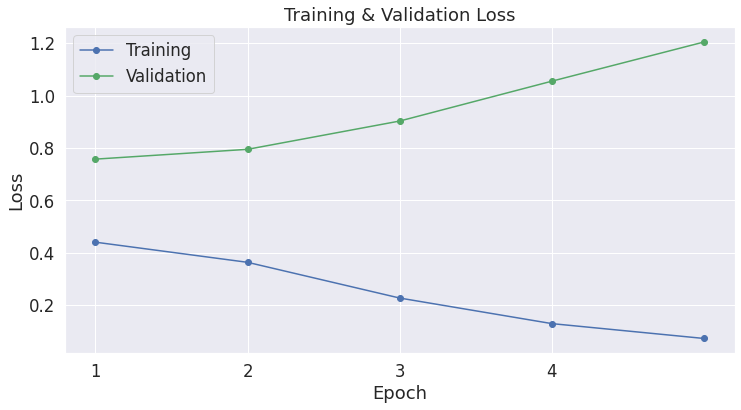

In [115]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [116]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The GPT-2 model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:2]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[2:14]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-2:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))
    

The GPT-2 model has 148 different named parameters.

==== Embedding Layer ====

transformer.wte.weight                                  (50257, 768)
transformer.wpe.weight                                   (1024, 768)

==== First Transformer ====

transformer.h.0.ln_1.weight                                   (768,)
transformer.h.0.ln_1.bias                                     (768,)
transformer.h.0.attn.c_attn.weight                       (768, 2304)
transformer.h.0.attn.c_attn.bias                             (2304,)
transformer.h.0.attn.c_proj.weight                        (768, 768)
transformer.h.0.attn.c_proj.bias                              (768,)
transformer.h.0.ln_2.weight                                   (768,)
transformer.h.0.ln_2.bias                                     (768,)
transformer.h.0.mlp.c_fc.weight                          (768, 3072)
transformer.h.0.mlp.c_fc.bias                                (3072,)
transformer.h.0.mlp.c_proj.weight                        (3072

In [2]:
step = 0
# model.playmode = True
model = model.to('cpu')
while True:
    context = input(">> User:")
    if context == "I am done talking":
      print("DialoGPT: Ok bye bye")
      break
    # encode the new user input, add the eos_token and return a tensor in Pytorch
    new_user_input_ids1 = tokenizer(context, return_tensors='pt').input_ids

    # append the new user input tokens to the chat history
    bot_input_ids1 = torch.cat([chat_history_ids1, new_user_input_ids1], dim=-1) if step > 0 else new_user_input_ids1

    # generated a response while limiting the total chat history to 1000 tokens, 
    chat_history_ids1 = model.generate(bot_input_ids1, max_length=1000, return_dict=True)
    step += 1
    # pretty print last ouput tokens from bot
    print("DialoGPT: {}".format(tokenizer.decode(chat_history_ids1[:, bot_input_ids1.shape[-1]:][0], skip_special_tokens=True)))

NameError: ignored

In [125]:
print(model.device)

print(bot_input_ids1.device)

# Can't be different

cuda:0
cpu


In [ ]:
# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))
